<a href="https://colab.research.google.com/github/guyyariv/AI-Beat-Maker/blob/master/google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
"""
Inputs
"""
import random
import numpy as np
# import pydub
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display

# import magenta


import scipy.io.wavfile as wav
import scipy.signal as signal
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import soundfile as sf
from scipy.ndimage import filters
import os, sys
from scipy import signal
from numba import jit


In [2]:

"""
This function will plot desired graphs
"""


def plot_graphs(audio, samp_rate, times, onset_env, onset_fr, sign_changes):
    fig, axs = plt.subplots(2)
    axs[0].plot(audio)
    axs[0].set_title("audio")
    axs[1].plot(times * samp_rate, onset_env)
    axs[1].vlines(times[onset_fr] * samp_rate, 0, onset_env.max(), 'r', linestyles='--')
    axs[1].set_title("env")
    plt.show()

    S = np.abs(librosa.stft(audio))
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.show()

    plt.plot(times, onset_env)
    plt.vlines(times[onset_fr], 0, onset_env.max(), 'r', linestyles='--')
    plt.show()

    plt.plot(times, onset_env)
    plt.vlines(times[np.argwhere(sign_changes > 0)], 0, onset_env.max(), 'r', linestyles='--')
    plt.show()

    Xdb = librosa.amplitude_to_db(abs(librosa.stft(audio)))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=samp_rate, x_axis='time', y_axis='hz')
    #If to pring log of frequencies
    librosa.display.specshow(Xdb, sr=samp_rate, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()


    # hop_length = 512
    fig, ax = plt.subplots(nrows=2, sharex=True)
    # times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=audio, sr=samp_rate)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram')
    ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    ax[1].legend()
    plt.show()

In [3]:

def get_wav_data(audio_path):
    audio_data, sample_rate = librosa.load(audio_path)
    tempo, beats = librosa.beat.beat_track(audio_data, sr=sample_rate)
    return audio_data, sample_rate, tempo, beats


"""
This function will track the beat and tempo, and will return an array of sliced sections accordingly.
"""


def beat_tracking_and_slice(audio_data, sample_rate):
    onset_envelope = librosa.onset.onset_strength(audio_data, sr=sample_rate)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_envelope, sr=sample_rate)
    times = librosa.times_like(onset_envelope, sr=sample_rate)
    X = librosa.stft(audio_data)
    Xdb = librosa.amplitude_to_db(abs(X))

    col_sums = Xdb.sum(axis=0)
    col_sign = np.sign(col_sums)
    sign_changes = ((np.roll(col_sign, 1) - col_sign) < 0).astype(int)

    peaks = (times[np.argwhere(sign_changes > 0)] * sample_rate).astype(int).flatten()
    return np.split(audio_data, peaks), sign_changes, times, onset_frames, onset_envelope
"""
This function will arrange the sliced sections randomly.
"""


def random_arrangement(sliced_audio, min_mult, max_mult):
    rearranged = np.array([])

    # shuffle slices
    random.shuffle(sliced_audio)

    # repeat and remix
    rnd_int = np.random.randint(min_mult, max_mult, size=len(sliced_audio))
    for slice, rnd in zip(sliced_audio, rnd_int):
        repeat = np.tile(slice, rnd)
        rearranged = np.append(rearranged, repeat)

    return rearranged


"""
This function will add drums to the given sample.
"""


def drums():
    pass


"""
This function will 
"""


def novelty_detection():
    pass


"""
This function will 
"""


def pitch_and_chord_detecion():
    pass


In [26]:
class OnsetDetection:
    def __calculate_local_energy_function(self, x, window):
        """
        Calculate local energy function
        :param x (np.ndarray): Signal
        :param window
        :return: local energy function
        """
        energy_local = np.convolve(x ** 2, window ** 2, 'same')
        return energy_local

    def __calculate_logarithmic_compression(self, signal, gamma):
        """
        :param energy: local energy function
        :param gamma: Parameter for logarithmic compression
        :return: logarithmic compression
        """
        return np.log(1 + gamma * signal)

    def __calculate_discrete_derivative(self, signal):
        """
        :param energy: local energy function
        :return: discrete derivative
        """
        return np.diff(signal)

    def __compute_local_average(self, x, M):
        """
        Compute local average of signal
        :param x:
        :param M:
        :return:
        """
        L = len(x)
        local_average = np.zeros(L)
        for m in range(L):
            a = max(m - M, 0)
            b = min(m + M + 1, L)
            local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
        return local_average

    def __principal_argument(self, value):
        """
        Principal argument function
        :param value (or vector of values)
        :return: Principle value of v
        """
        w = np.mod(value + 0.5, 1) - 0.5
        return w

    def energy_based_novelty(self, x, Fs=1, N=2048, H=128, gamma=10.0,
                               norm=True):
        """
        Compute energy-based novelty function
        :param x (np.ndarray): Signal
        :param Fs: Sampling rate
        :param N: Window size
        :param H: Hop size
        :param gamma: Parameter for logarithmic compression
        :param norm (bool): Apply max norm
        :return: novelty_energy (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
        """
        window = signal.windows.hann(N)
        Fs_feature = Fs / H

        energy_local = self.__calculate_local_energy_function(x, window)[::H]
        if gamma:
            energy_local = self.__calculate_logarithmic_compression(energy_local, gamma)
        discrete_derivative = self.__calculate_discrete_derivative(energy_local)

        # half wave rectification
        novelty_energy = np.copy(discrete_derivative)
        novelty_energy[discrete_derivative < 0] = 0

        if norm:
            max_value = max(novelty_energy)
            if max_value > 0:
                novelty_energy = novelty_energy / max_value
        return novelty_energy, Fs_feature

    def spectral_based_novelty(self, x, Fs=1, N=1024, H=256, gamma=100.0,
                               M=10, norm=True, librosa_window='hanning'):
        """
        Compute spectral-based novelty function
        :param x (np.ndarray): Signal
        :param Fs: Sampling rate
        :param N: Window size
        :param H: Hop size
        :param gamma: Parameter for logarithmic compression
        :param norm (bool): Apply max norm
        :param M: Size (frames) of local average
        :param librosa_window: window for stft
        :return: novelty_spectrum (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
        """
        Fs_feature = Fs / H
        stft = librosa.stft(x, n_fft=N, hop_length=H, win_length=N,
                         window=librosa_window)
        X = np.abs(stft)
        if gamma:
            X = self.__calculate_logarithmic_compression(X, gamma)
        discrete_derivative = self.__calculate_discrete_derivative(X)

        # half wave rectification
        novelty_spectrum = np.copy(discrete_derivative)
        novelty_spectrum[discrete_derivative < 0] = 0
        novelty_spectrum = np.sum(novelty_spectrum, axis=0)
        novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
        if M > 0:
            local_average = self.__compute_local_average(novelty_spectrum, M)
            novelty_spectrum = novelty_spectrum - local_average
            novelty_spectrum[novelty_spectrum < 0] = 0.0
        if norm:
            max_value = max(novelty_spectrum)
            if max_value > 0:
                novelty_spectrum = novelty_spectrum / max_value
        return novelty_spectrum, Fs_feature

    def phase_based_novelty(self, x, Fs=1, N=1024, H=64, M=40, norm=True,
                            window='hanning'):
        X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N,
                         window=window)
        Fs_feature = Fs / H
        phase = np.angle(X) / (2 * np.pi)
        phase_diff = self.__principal_argument(np.diff(phase, axis=1))
        phase_diff2 = self.__principal_argument(np.diff(phase_diff, axis=1))
        novelty_phase = np.sum(np.abs(phase_diff2), axis=0)
        novelty_phase = np.concatenate((novelty_phase, np.array([0, 0])))
        if M > 0:
            local_average = self.__compute_local_average(novelty_phase, M)
            novelty_phase = novelty_phase - local_average
            novelty_phase[novelty_phase < 0] = 0
        if norm:
            max_value = np.max(novelty_phase)
            if max_value > 0:
                novelty_phase = novelty_phase / max_value
        return novelty_phase, Fs_feature
      
    def complex_domain_novelty(self, x, Fs=1, N=1024, H=64, gamma=10.0, M=40, norm=True):
        X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N,
                         window='hanning')
        Fs_feature = Fs / H
        mag = np.abs(X)
        if gamma > 0:
            mag = np.log(1 + gamma * mag)
        phase = np.angle(X) / (2 * np.pi)
        phase_diff = np.diff(phase, axis=1)
        phase_diff = np.concatenate(
            (phase_diff, np.zeros((phase.shape[0], 1))), axis=1)
        X_hat = mag * np.exp(2 * np.pi * 1j * (phase + phase_diff))
        X_prime = np.abs(X_hat - X)
        X_plus = np.copy(X_prime)
        for n in range(1, X.shape[0]):
            idx = np.where(mag[n, :] < mag[n - 1, :])
            X_plus[n, idx] = 0
        novelty_complex = np.sum(X_plus, axis=0)
        if M > 0:
            local_average = self.__compute_local_average(novelty_complex, M)
            novelty_complex = novelty_complex - local_average
            novelty_complex[novelty_complex < 0] = 0
        if norm:
            max_value = np.max(novelty_complex)
            if max_value > 0:
                novelty_complex = novelty_complex / max_value
        return novelty_complex, Fs_feature

86.1328125
172.265625
344.53125
344.53125


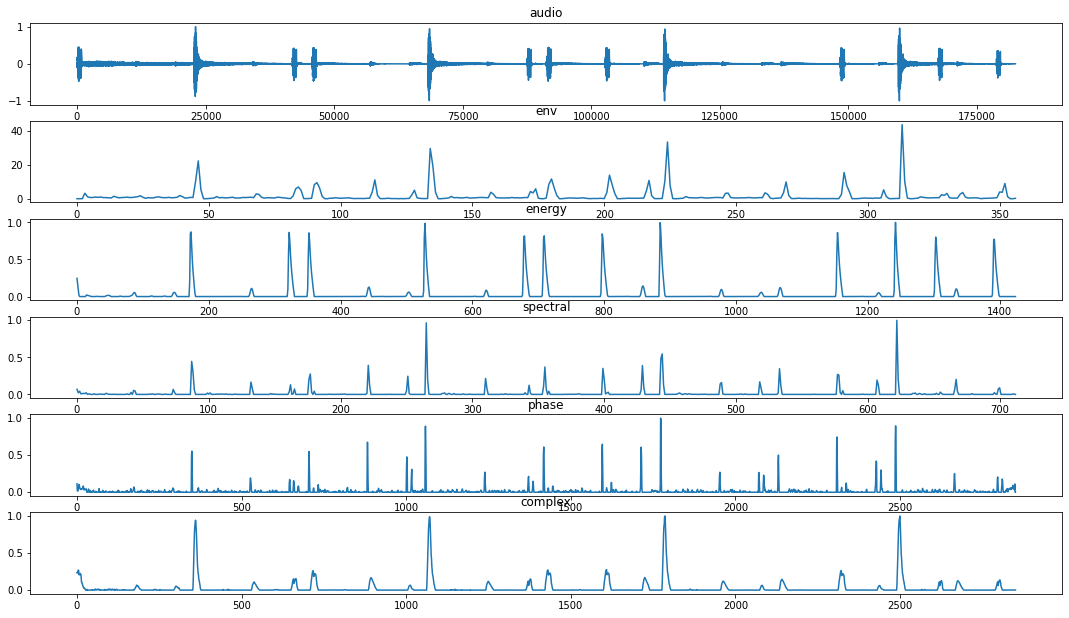

In [35]:
if __name__ == '__main__':
    audio_path = "resources_test.wav"
    audio_data, sample_rate, tempo, beats = get_wav_data(audio_path)
    slices, sign_times, time, ons_fr, ons_env = beat_tracking_and_slice(audio_data, sample_rate)
    # min_rep = 1
    # max_rep = 7
    # rem = random_arrangement(slices, min_rep, max_rep)
    # plot_graphs(audio_data, sample_rate, time, ons_env, ons_fr, sign_times)
    # sf.write('test_one_pr_file.wav', rem, sample_rate)
    temp = OnsetDetection()
    novelty_spectrum, Fs_feature1 = temp.spectral_based_novelty(x=audio_data, Fs=sample_rate)
    print(Fs_feature1)
    novelty_energy, Fs_feature2 = temp.energy_based_novelty(x=audio_data, Fs=sample_rate)
    print(Fs_feature2)
    novelty_phase, Fs_feature3 = temp.phase_based_novelty(x=audio_data, Fs=sample_rate)
    print(Fs_feature3)
    novelty_complex, Fs_feature4 = temp.complex_domain_novelty(x=audio_data, Fs=sample_rate)
    print(Fs_feature4)

    fig, axs = plt.subplots(6)
    fig.set_size_inches(18.5, 10.5)
    axs[0].plot(audio_data)
    axs[0].set_title("audio")
    axs[1].plot(ons_env)
    axs[1].set_title("env")
    axs[2].plot(novelty_energy)
    axs[2].set_title("energy")
    axs[3].plot(novelty_spectrum)
    axs[3].set_title("spectral")
    axs[4].plot(novelty_phase)
    axs[4].set_title("phase")
    axs[5].plot(novelty_complex)
    axs[5].set_title("complex")
    plt.show()


# New Section